# Calculating How Distortion Changes with Weights

## Set-up

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
NUM_VOTERS = 3
NUM_CANDIDATES = 10

CANDIDATES = np.arange(NUM_CANDIDATES)

In [3]:
VOTERS = []
for _ in range(NUM_VOTERS):
    vec = np.random.random(NUM_CANDIDATES)
    ut_func = (lambda v: lambda c: v[c])(vec)
    VOTERS.append(ut_func)

VOTERS_DISTR = np.random.random(NUM_VOTERS)

In [4]:
VOTERS[0](2)

0.9473705646312793

In [5]:
def borda_scores(voters, candidates, voters_distr=None, candidates_distr=None, beta=1.0):
    if voters_distr is None:
        voters_distr = np.array([1.0 / len(voters) for v in voters])
    if candidates_distr is None:
        candidates_distr = np.array([1.0 / len(candidates) for c in candidates])
    
    bs = [0 for _ in candidates]
    for j, candidate in enumerate(candidates):
        for k, alternate in enumerate(candidates):

            u_candidate = np.array([v(candidate) for v in voters])
            u_alternate = np.array([v(alternate) for v in voters])
            sigmoided = voters_distr * 1.0 / (1.0 + np.exp(-beta * (u_candidate - u_alternate)))
            exp = sigmoided.sum()
            
            bs[j] += candidates_distr[k] * exp
            
    return np.array(bs)

In [6]:
candidate = 0
alternate = 1

u_candidate = np.array([v(candidate) for v in VOTERS])
u_alternate = np.array([v(alternate) for v in VOTERS])
sigmoided = VOTERS_DISTR * 1.0 / (1.0 + np.exp(-1.0 * (u_candidate - u_alternate)))

In [7]:
sigmoided.sum()

0.6855692468032815

In [8]:
i = 2
(VOTERS_DISTR * 1.0 / (1.0 + np.exp(-1.0 * (u_candidate - u_alternate)))).sum()

0.6855692468032815

## Evaluate Borda Counts Function to Check That It's Correct

In [9]:
import random

random.seed(0)

VOTERS_EASY = []
for _ in range(50):
    variable = random.uniform(0, 1)
    print(variable)
    ut_func = lambda var: lambda x: 2 / np.pi * np.arctan(var * x)
    ut_func = ut_func(variable)
    VOTERS_EASY.append(ut_func)

0.8444218515250481
0.7579544029403025
0.420571580830845
0.25891675029296335
0.5112747213686085
0.4049341374504143
0.7837985890347726
0.30331272607892745
0.4765969541523558
0.5833820394550312
0.9081128851953352
0.5046868558173903
0.28183784439970383
0.7558042041572239
0.6183689966753316
0.25050634136244054
0.9097462559682401
0.9827854760376531
0.8102172359965896
0.9021659504395827
0.3101475693193326
0.7298317482601286
0.8988382879679935
0.6839839319154413
0.47214271545271336
0.1007012080683658
0.4341718354537837
0.6108869734438016
0.9130110532378982
0.9666063677707588
0.47700977655271704
0.8653099277716401
0.2604923103919594
0.8050278270130223
0.5486993038355893
0.014041700164018955
0.7197046864039541
0.39882354222426875
0.824844977148233
0.6681532012318508
0.0011428193144282783
0.49357786646532464
0.8676027754927809
0.24391087688713198
0.32520436274739006
0.8704712321086546
0.19106709150239054
0.5675107406206719
0.23861592861522019
0.9675402502901433


In [10]:
BS = borda_scores(VOTERS_EASY, CANDIDATES)

In [11]:
BS

array([0.35697447, 0.43069598, 0.47564565, 0.50187253, 0.51859109,
       0.53006407, 0.53838201, 0.54467019, 0.5495823 , 0.55352172])

Okay! They match. Moving on.

## Writing a Peeling Version

In [12]:
def one_round_ranking(voters, candidates, voters_distr=None, candidates_distr=None, beta=1.0):
    bs = borda_scores(voters=voters, candidates=candidates, voters_distr=voters_distr, candidates_distr=candidates_distr, beta=beta)
    return np.argsort(-bs)

In [13]:
def winner_peeling_ranking(voters, candidates, voters_distr=None, candidates_distr=None, beta=1.0):
    wpr = []
    for r in range(len(candidates)):
        bs = borda_scores(voters=voters, candidates=candidates, voters_distr=voters_distr, candidates_distr=candidates_distr, beta=beta)
        winner = candidates[np.argmax(bs)]
        wpr.append(winner)

        remaining_idxs = (candidates != winner)
        candidates = candidates[remaining_idxs]
        if candidates_distr:
            candidates_distr = candidates_distr[remaining_idxs]

    return np.array(wpr)

In [14]:
orr = one_round_ranking(voters=VOTERS_EASY, candidates=CANDIDATES)
print(orr)

[9 8 7 6 5 4 3 2 1 0]


In [15]:
wpr = winner_peeling_ranking(voters=VOTERS_EASY, candidates=CANDIDATES)
print(wpr)

[9 8 7 6 5 4 3 2 1 0]


In [16]:
def avg_util(voters, candidates, voters_distr=None):
    if voters_distr is None:
        voters_distr = np.array([1.0 / len(voters) for v in voters])

    exp_u = np.zeros(len(candidates))
    for i, voter in enumerate(voters):
        voter_u = np.vectorize(voter)(candidates)
        exp_u += voters_distr[i] * voter_u
    return exp_u

In [17]:
def true_ranking(voters, candidates, voters_distr=None):
    exp_u = avg_util(voters=voters, candidates=candidates, voters_distr=voters_distr)

    return np.argsort(-exp_u)

In [18]:
tr = true_ranking(voters=VOTERS_EASY, candidates=CANDIDATES)
print(tr)

[9 8 7 6 5 4 3 2 1 0]


In [19]:
from scipy.optimize import minimize
def distortion(voters, candidates, true_ranking, your_ranking, voters_distr=None, weights=None):
    if voters_distr is None:
        voters_distr = np.array([1.0 / len(voters) for v in voters])

    if weights is not None:
        avg_utils = avg_util(voters=voters, candidates=candidates, voters_distr=voters_distr)
        numerator = avg_utils[true_ranking] @ weights
        denominator = avg_utils[your_ranking] @ weights
        return numerator / denominator
    
    # else:
    #     def f(deltas, tr, yr):
    #         weights = [0 for _ in range(len(deltas))]
    #         weights[-1] = deltas[-1]
    #         for i in range(len(deltas)):
    #             weights[len(deltas) - 2 - i] = weights[len(deltas) - 1 - i + 1] + deltas[len(deltas) - 2 - i]
            
    #         weights = np.array(weights)
    #         return (tr @ weights) / (yr @ weights)

    #     res = minimize(
    #         fun=lambda deltas, tr, yr: - f(deltas, tr, yr),
    #         x0=np.zeros(len(true_ranking)),
    #         method="L-BFGS-B"
    #     )

    #     delta_opt = res.x


```
from scipy.optimize import minimize
import numpy as np

def f(x):
    return -(x[0]**2 + x[1]**2)  # concave, maximize

res = minimize(
    fun=lambda x: -f(x),   # negate for maximization
    x0=np.array([0.5, 0.5]),
    bounds=[(0, 1), (0, 1)],
    method="L-BFGS-B"
)

x_opt = res.x

```


In [20]:
import numpy as np
from scipy.optimize import minimize

tr = true_ranking(VOTERS_EASY, CANDIDATES)
# yr = one_round_ranking(VOTERS_EASY, CANDIDATES)
yr = np.arange(len(CANDIDATES))
avg_utils = avg_util(voters=VOTERS_EASY, candidates=CANDIDATES)

def f(deltas, tr, yr):
    n = len(deltas)
    weights = np.zeros(n)

    # last weight
    weights[-1] = deltas[-1]

    # build backwards
    for i in range(n - 2, -1, -1):
        weights[i] = weights[i + 1] + deltas[i]

    # elementwise ops
    value = (avg_utils[tr] @ weights) / (avg_utils[yr] @ weights)

    return value  # scalar


In [21]:
print(tr, yr)

[9 8 7 6 5 4 3 2 1 0] [0 1 2 3 4 5 6 7 8 9]


In [22]:
def objective(deltas):
    return -f(deltas, tr, [9, 8, 7, 6, 5, 3, 4, 2, 1, 0])

res = minimize(
    fun=objective,
    x0=np.ones(len(tr)),
    bounds=[(0, None)] * len(tr),
    method="L-BFGS-B"
)

delta_opt = res.x
value = -res.fun
print(delta_opt)


[0.         0.         0.         0.         0.         6.98221861
 0.         0.         0.         0.        ]


In [23]:
res.fun

-1.0151145922818654

In [24]:
w = np.arange(5)
x = np.ones(5)

In [25]:
w * x

array([0., 1., 2., 3., 4.])

In [26]:
w @ x

10.0

In [27]:
objective(delta_opt)

-1.0151145922818654

In [28]:
avg_util(voters=VOTERS_EASY, candidates=CANDIDATES)

array([0.        , 0.31778666, 0.50263899, 0.60945009, 0.67746581,
       0.72420579, 0.7581656 , 0.78389848, 0.80404595, 0.82023823])

In [29]:
n = len(delta_opt)
weights = np.zeros(n)

# last weight
weights[-1] = delta_opt[-1]

# build backwards
for i in range(n - 2, -1, -1):
    weights[i] = weights[i + 1] + delta_opt[i]

distortion(voters=VOTERS_EASY, candidates=CANDIDATES, true_ranking=tr, your_ranking=yr, weights=weights)

1.6132592206375413

In [30]:
weights

array([6.98221861, 6.98221861, 6.98221861, 6.98221861, 6.98221861,
       6.98221861, 0.        , 0.        , 0.        , 0.        ])

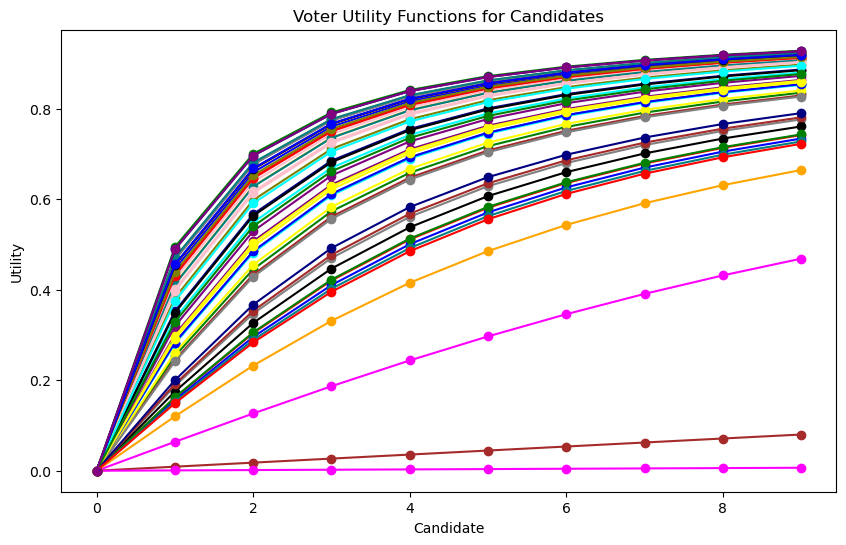

In [31]:
plt.figure(figsize=(10, 6))
cmap = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
        'magenta', 'yellow', 'black', 'teal', 'navy']
for i, voter in enumerate(VOTERS_EASY):
    utilities = [voter(c) for c in CANDIDATES]
    plt.plot(CANDIDATES, utilities, color=cmap[i % len(cmap)], marker='o', label=f'Voter {i+1}' if i < 10 else "")

# plt.plot(CANDIDATES, BS, label='Borda Scores', color='red', linewidth=2, marker='o')
plt.title('Voter Utility Functions for Candidates')
plt.xlabel('Candidate')
plt.ylabel('Utility')
plt.show()

## Simulating Samples

In [1]:
from utils_2 import generate_uniform_random_voters, avg_util, borda_scores, true_ranking, one_round_ranking, winner_peeling_ranking, distortion, distortion_with_weights, plot_utility_curves, generate_normal_random_voters

In [2]:
import numpy as np

In [44]:
NUM_ROUNDS = 1000
NUM_VOTERS = 3
NUM_CANDIDATES = 10

CANDIDATES = np.arange(NUM_CANDIDATES)

beta = []
orr_dists = []
wpr_dists = []
avg_diff_squareds = []
stds = []

for i in range(NUM_ROUNDS):
    std = 2.0 * np.random.random(1)[0]
    VOTERS = generate_normal_random_voters(num_voters=NUM_VOTERS, num_candidates=NUM_CANDIDATES, std=std)
    stds.append(std)
    # VOTERS_DISTR = np.random.random(NUM_VOTERS)
    # VOTERS_DISTR /= VOTERS_DISTR.sum()
    VOTERS_DISTR = None

    # CANDIDATES_DISTR = np.random.random(NUM_CANDIDATES)
    # CANDIDATES_DISTR /= CANDIDATES_DISTR.sum()
    CANDIDATES_DISTR = None

    # BETA = np.random.random(1)[0]
    BETA = 100 * np.random.random(1)[0] + 1e-6
    # BETA = 10
    orr = one_round_ranking(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR, candidates_distr=CANDIDATES_DISTR, beta=BETA)
    orr_dist, orr_weights = distortion(voters=VOTERS, candidates=CANDIDATES, your_ranking=orr, voters_distr=VOTERS_DISTR, return_weights=True)

    # weights = np.arange(NUM_CANDIDATES, 0, -1).astype(np.float64)
    # weights /= weights.sum()
    # orr_dist2 = distortion_with_weights(voters=VOTERS, candidates=CANDIDATES, your_ranking=orr, weights=weights, voters_distr=VOTERS_DISTR)

    wpr = winner_peeling_ranking(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR, candidates_distr=CANDIDATES_DISTR, beta=BETA)
    wpr_dist, wpr_weights = distortion(voters=VOTERS, candidates=CANDIDATES, your_ranking=wpr, voters_distr=VOTERS_DISTR, return_weights=True)
    tr = true_ranking(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR)

    avg_utils = avg_util(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR)

    avg_diff_squared = 0
    for i, c1 in enumerate(CANDIDATES):
        for j, c2 in enumerate(CANDIDATES):
            avg_diff_squared += 1 / (len(CANDIDATES) * len(CANDIDATES)) * (np.abs(avg_utils[i] - avg_utils[j])) ** 3

    # print(avg_diff_squared)
    avg_diff_squareds.append(avg_diff_squared)

    beta.append(BETA)
    # orr_tr.append(np.abs(orr_dist - wpr_dist))
    orr_dists.append(orr_dist)
    wpr_dists.append(wpr_dist)

    # if (orr_dist > 1.2 or wpr_dist > 1.2) and orr_weights[0] < 1.0:
    # if (orr_dist > 1.6 or wpr_dist > 1.6):
    # if (orr_dist != wpr_dist):
    #     print(f'\nROUND {i}')
    #     print('one round ranking:', orr)
    #     print('one round distortion:',orr_dist)
    #     print('one round weights', orr_weights)

    #     # print(orr_dist2)
    #     # print(weights)

    #     print('winner peeling ranking:', wpr)
    #     print('winner peeling distortion:', wpr_dist)
    #     print('winner peeling weights', wpr_weights)

    #     for i, v in enumerate(VOTERS):
    #         print(f'voter {i}:', [v(c) for c in CANDIDATES])

    #     print('voter distribution:', VOTERS_DISTR)
    #     print('candidate distribution:', CANDIDATES_DISTR)
    #     print('beta:', BETA)

    #     tr = true_ranking(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR)

    #     # max_dist_idx = 0
    #     # max_dist = 0
    #     # avg_utils = avg_util(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR)
    #     # dists = []
    #     # for i in range(NUM_CANDIDATES):
    #     #     d = avg_utils[wpr[i]] / avg_utils[tr[i]]
    #     #     if d > max_dist:
    #     #         max_dist = d
    #     #         max_dist_idx = i
            
    #     print('true ranking:', tr)
    #     print('max_dist_idx:', max_dist_idx)
    #     print('max_dist:', max_dist)
    #     print('avg_util:', avg_utils)

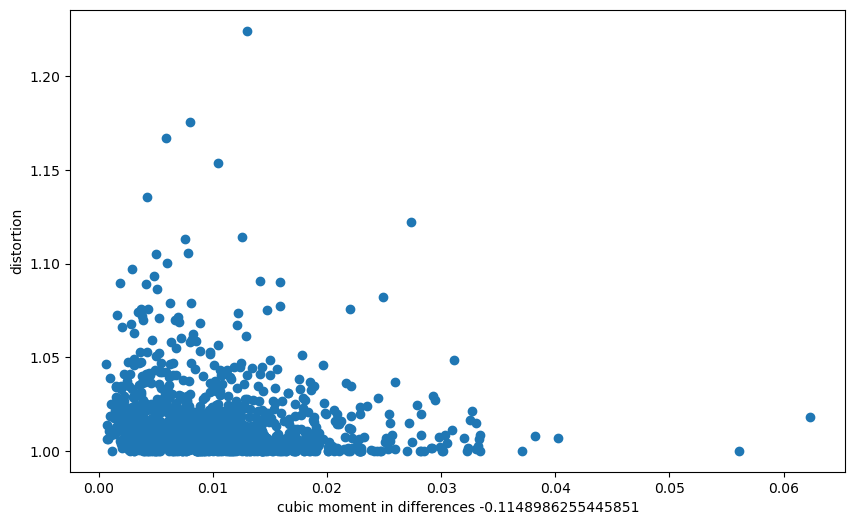

In [4]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(avg_diff_squareds, orr_dists)

cc = np.corrcoef(avg_diff_squareds, wpr_dists)[0, 1]
plt.xlabel(f'cubic moment in differences {cc}')
plt.ylabel('distortion')
plt.show()

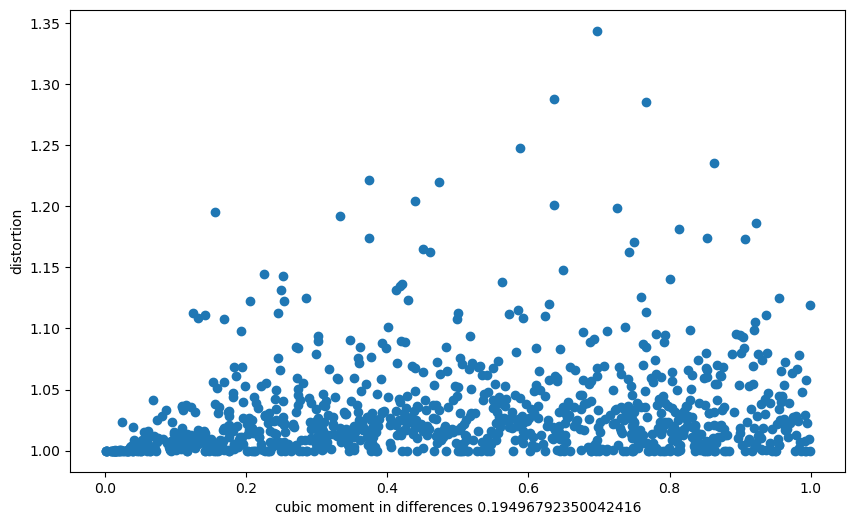

In [4]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(stds, orr_dists)

cc = np.corrcoef(stds, orr_dists)[0, 1]
plt.xlabel(f'cubic moment in differences {cc}')
plt.ylabel('distortion')
plt.show()

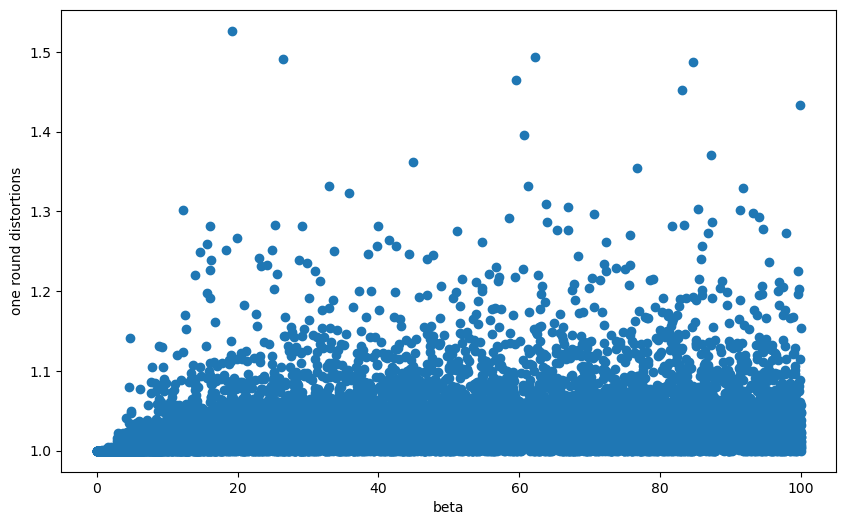

In [30]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(beta, orr_dists)
plt.xlabel('beta')
plt.ylabel('one round distortions')
plt.show()

In [33]:
corr = np.corrcoef(beta, orr_dists)[0, 1]

In [34]:
print(corr)

0.20723418392504012


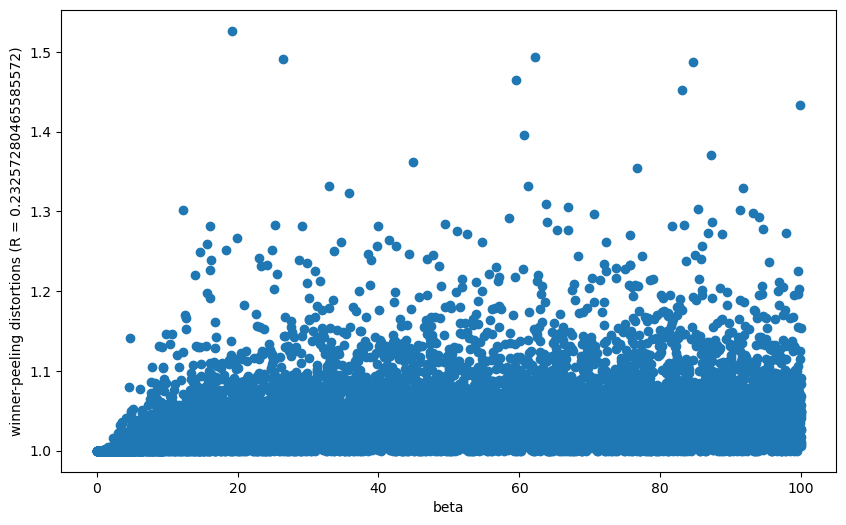

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(beta, wpr_dists)
plt.xlabel('beta')
corr = np.corrcoef(beta, wpr_dists)[0, 1]
plt.ylabel(f'winner-peeling distortions (R = {corr})')
plt.show()

In [45]:
from utils_2 import generate_agreement_random_voters

NUM_ROUNDS = 2000
NUM_VOTERS = 10
NUM_CANDIDATES = 10

CANDIDATES = np.arange(NUM_CANDIDATES)

betas = []
orr_dists = []
wpr_dists = []
avg_diff_squareds = []
stds = []

for i in range(NUM_ROUNDS):
    std = 2.0 * np.random.random(1)[0]
    # std = 0.25
    VOTERS = generate_agreement_random_voters(num_voters=NUM_VOTERS, num_candidates=NUM_CANDIDATES, agreement=std)
    # VOTERS = generate_uniform_random_voters(NUM_VOTERS, NUM_CANDIDATES)
    stds.append(std)
    # VOTERS_DISTR = np.random.random(NUM_VOTERS)
    # VOTERS_DISTR /= VOTERS_DISTR.sum()
    VOTERS_DISTR = None

    # CANDIDATES_DISTR = np.random.random(NUM_CANDIDATES)
    # CANDIDATES_DISTR /= CANDIDATES_DISTR.sum()
    CANDIDATES_DISTR = None

    # BETA = np.random.random(1)[0]
    # BETA = 100 * np.random.random(1)[0] + 1e-6
    BETA = 80
    orr = one_round_ranking(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR, candidates_distr=CANDIDATES_DISTR, beta=BETA)
    orr_dist, orr_weights = distortion(voters=VOTERS, candidates=CANDIDATES, your_ranking=orr, voters_distr=VOTERS_DISTR, return_weights=True)

    wpr = winner_peeling_ranking(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR, candidates_distr=CANDIDATES_DISTR, beta=BETA)
    wpr_dist, wpr_weights = distortion(voters=VOTERS, candidates=CANDIDATES, your_ranking=wpr, voters_distr=VOTERS_DISTR, return_weights=True)
    tr = true_ranking(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR)

    # avg_utils = avg_util(voters=VOTERS, candidates=CANDIDATES, voters_distr=VOTERS_DISTR)

    # avg_diff_squared = 0
    # for i, c1 in enumerate(CANDIDATES):
    #     for j, c2 in enumerate(CANDIDATES):
    #         avg_diff_squared += 1 / (len(CANDIDATES) * len(CANDIDATES)) * (np.abs(avg_utils[i] - avg_utils[j])) ** 3

    # # print(avg_diff_squared)
    # avg_diff_squareds.append(avg_diff_squared)

    betas.append(BETA)
    orr_dists.append(orr_dist)
    wpr_dists.append(wpr_dist)

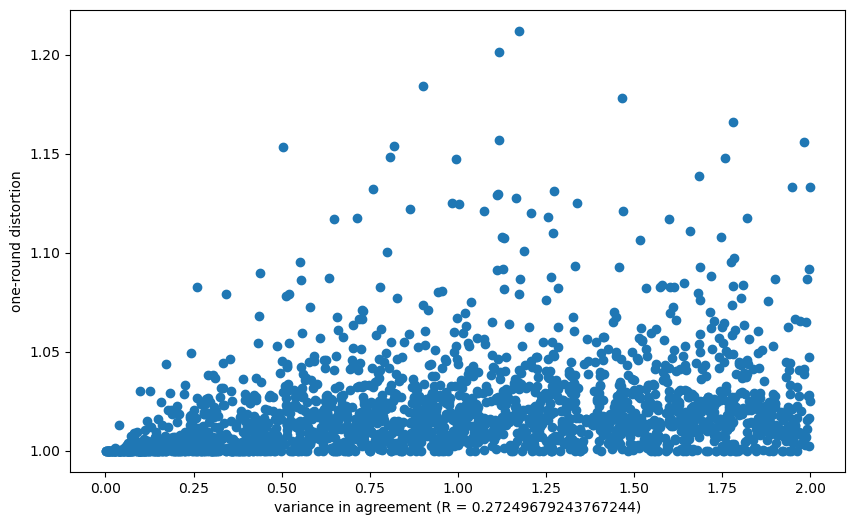

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(stds, orr_dists)

cc = np.corrcoef(stds, orr_dists)[0, 1]
plt.xlabel(f'variance in agreement (R = {cc})')
plt.ylabel('one-round distortion')
plt.show()

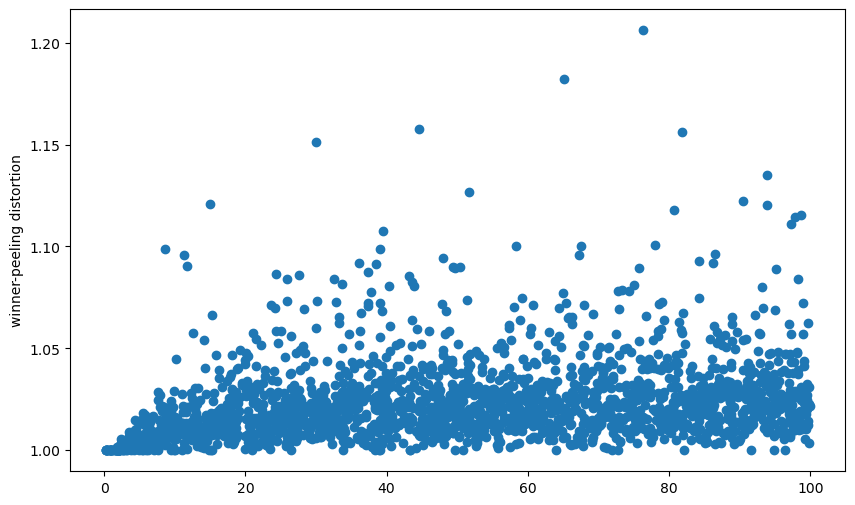

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(betas, np.array(wpr_dists))

# cc = np.corrcoef(betas, wpr_dists)[0, 1]
# plt.xlabel(f'variance in agreement (R = {cc})')
plt.ylabel('winner-peeling distortion')
plt.show()

In [43]:
r, p = pearsonr(betas, wpr_dists)
print(r, p)

0.2679021143370177 3.2215968676678686e-34


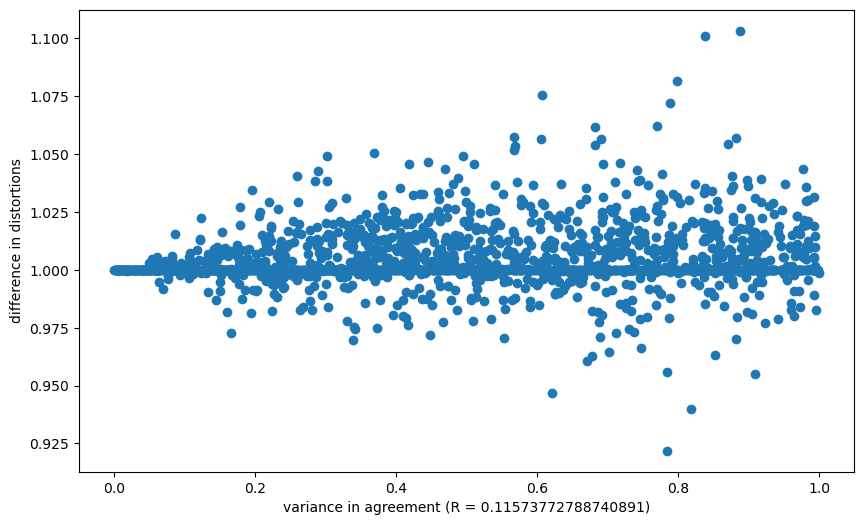

In [29]:
plt.figure(figsize=(10, 6))

x = stds
y = np.abs(np.array(orr_dists) - np.array(wpr_dists))
y = np.array(wpr_dists)/np.array(orr_dists)

plt.scatter(x, y)
cc = np.corrcoef(x, y)[0, 1]
plt.xlabel(f'variance in agreement (R = {cc})')
plt.ylabel('difference in distortions')
plt.show()

In [18]:
from scipy.stats import pearsonr

r, p = pearsonr(x, y)

In [19]:
r, p

(0.278323887025673, 6.64875848936772e-37)